---
<a id='step3'></a>
## Step 1: Create a CNN to Classify Brain CT and MRI images (from Scratch)


### Data Loaders for Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of the images (located at `data/train`, `data/valid`, and `data/test`, respectively).   If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [26]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

use_cuda = torch.cuda.is_available()


batch_size = 20
num_workers = 0

data_dir = '/home/sebi/Desktop/CT-MRI/data'

train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

dim=224


data_transforms = {'train': transforms.Compose([
                                     transforms.Resize(dim),
                                     transforms.transforms.RandomResizedCrop(dim),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(5),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std=[0.5, 0.5, 0.5])]),
                   'val': transforms.Compose([transforms.Resize(dim),
                                     transforms.CenterCrop(dim),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std=[0.5, 0.5, 0.5])]),
                   'test': transforms.Compose([transforms.Resize(size=(dim,dim)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std=[0.5, 0.5, 0.5])])
                  }


train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)


In [27]:
#train_loader.dataset


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

# A function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

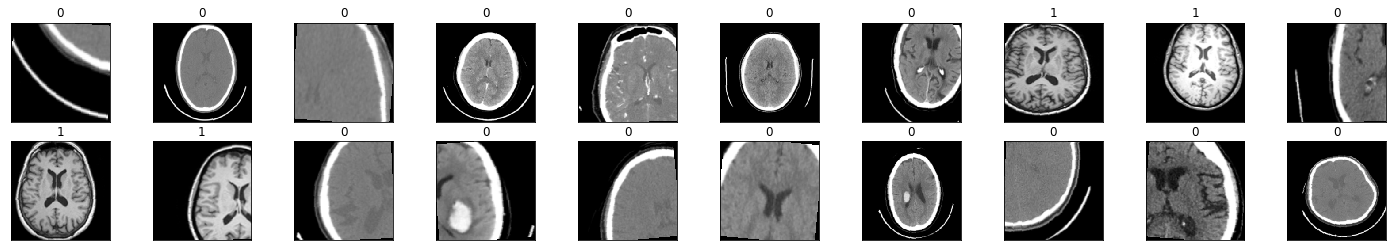

In [29]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx].numpy())

###  Model Architecture

A CNN to classify CT and MRI images.  

In [30]:
#use_cuda=False
import torch.nn as nn
import torch.nn.functional as F
    
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 14 * 14 -> 500)
        self.fc1 = nn.Linear(128*7*7, 500)
        # linear layer (500 -> 113)
        self.fc2 = nn.Linear(500, 2)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 128 * 7*7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, without activation function
        x = self.fc2(x)
        return x



# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


###  Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [31]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

###  Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [32]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss

        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)
            #print(train_loss)
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            output = model(data)
            
          
            loss = criterion(output, target)
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)
            
  
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
            
    # return trained model
    return model




In [33]:
# Train the model
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch,criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 0.598406 	Validation Loss: 0.293991
Validation loss decreased (inf --> 0.293991).  Saving model ...
Epoch: 2 	Training Loss: 0.360975 	Validation Loss: 0.080727
Validation loss decreased (0.293991 --> 0.080727).  Saving model ...
Epoch: 3 	Training Loss: 0.206604 	Validation Loss: 0.038879
Validation loss decreased (0.080727 --> 0.038879).  Saving model ...
Epoch: 4 	Training Loss: 0.177734 	Validation Loss: 0.040715
Epoch: 5 	Training Loss: 0.120530 	Validation Loss: 0.251156
Epoch: 6 	Training Loss: 0.094595 	Validation Loss: 0.018097
Validation loss decreased (0.038879 --> 0.018097).  Saving model ...
Epoch: 7 	Training Loss: 0.072736 	Validation Loss: 0.013999
Validation loss decreased (0.018097 --> 0.013999).  Saving model ...
Epoch: 8 	Training Loss: 0.069138 	Validation Loss: 0.024727
Epoch: 9 	Training Loss: 0.161717 	Validation Loss: 0.040208
Epoch: 10 	Training Loss: 0.066795 	Validation Loss: 0.029351
Epoch: 11 	Training Loss: 0.065685 	Validation Lo

<All keys matched successfully>

###  Test the Model

Use the code cell below to calculate and print the test loss and accuracy.  

In [38]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
loaders_scratch={'train': train_loader,'test': test_loader}
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.071437


Test Accuracy: 99% (109/110)


### Predict type of image with the Model

This function takes an image path as input and returns the type of images (`CT`or `MRI`) that is predicted by the model.  

The predicted image type is : CT


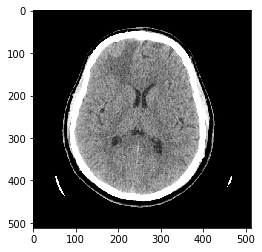

In [120]:

# list of class names by index, i.e. a name can be accessed like class_names[0]
#train_loader.dataset.classes
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt                        
%matplotlib inline   
import torchvision.transforms as transforms

class_names = [item[0:].replace("_", " ") for item in loaders_scratch['train'].dataset.classes]


def predict_image(img_path):
    # load the image and return the predicted image
    im=Image.open(img_path)
    
    in_transform = transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])

    
    
    image = in_transform(im)[:3,:,:].unsqueeze(0)
    if use_cuda:
        image=image.cuda()
    output = model_scratch(image)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
   
    
    return im,preds # predicted class index

#data_dir
image_files = np.array(glob(data_dir+"/*/*/*"))

img_path = image_files[500] # We introduce the image in this part to our model.


im, PredictedImage = predict_image(img_path)
plt.imshow(im)
print('The predicted image type is :',class_names[PredictedImage])